# ANZ virtual internship 
## Building a salary predicting model

Build a simple regression model to predict the annual salary for each customer using the attributes you identified above

How accurate is your model? Should ANZ use it to segment customers (for whom it does not have this data) into income brackets for reporting purposes?

For a challenge: build a decision-tree based model to predict salary. Does it perform better? How would you accurately test the performance of this model?

# Import libraries and data

In [328]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')
%matplotlib inline

### Load file

In [329]:
df = pd.read_excel('anz_new_feats.xlsx')
df.head(2)

,status,card_present_flag,account,currency,txn_description,merchant_id,first_name,balance,gender,age,...,state,annual_salary,avg_weekly_purch_num,avg_weekly_trans_num,no_trans_days,avg_trans_amount,max_amount,num_large_trans,avg_trans_amount_overall,med_balance
0,authorized,1.0,ACC-1598451071,AUD,POS,81c48296-73be-44a7-befa-d053f48ce7cd,Diana,35.39,F,26,...,QLD,56765,76,83,82,18,1452.2,4,45,1580.4
1,authorized,0.0,ACC-1598451071,AUD,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,Diana,21.20,F,26,...,QLD,56765,76,83,82,18,1452.2,4,45,1580.4


### Encoding categorical features

In [358]:
cat_feats = df[['status', 'txn_description', 'gender', 'state', 'age_bin']]

In [359]:
cat_feats = pd.get_dummies(cat_feats, drop_first=True)
cat_feats.head(2)

,status_posted,txn_description_PAY/SALARY,txn_description_PAYMENT,txn_description_PHONE BANK,txn_description_POS,txn_description_SALES-POS,gender_M,state_NT,state_QLD,state_SA,state_VIC,state_WA,age_bin_below20,age_bin_btwn20n40,age_bin_btwn40n60
0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0
1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0


In [360]:
num_feats = df[['balance', 'amount', 'annual_salary', 'avg_weekly_purch_num', 'avg_weekly_trans_num', 'no_trans_days', 
'avg_trans_amount', 'max_amount', 'num_large_trans', 'avg_trans_amount_overall', 'med_balance']]
num_feats.head(3)

,balance,amount,annual_salary,avg_weekly_purch_num,avg_weekly_trans_num,no_trans_days,avg_trans_amount,max_amount,num_large_trans,avg_trans_amount_overall,med_balance
0,35.39,16.25,56765,76,83,82,18,1452.2,4,45,1580.40
1,21.20,14.19,56765,76,83,82,18,1452.2,4,45,1580.40
2,5.71,6.42,52110,39,43,70,35,2349.6,7,78,1132.66


## Check correlation

In [361]:
num_feats.corr()['annual_salary'].sort_values(ascending=False)

annual_salary               1.000000
avg_trans_amount_overall    0.538656
med_balance                 0.258076
balance                     0.257159
amount                      0.091111
avg_trans_amount            0.044312
num_large_trans            -0.045275
avg_weekly_trans_num       -0.079352
max_amount                 -0.097739
no_trans_days              -0.172765
avg_weekly_purch_num       -0.189532
Name: annual_salary, dtype: float64

### Scale numerical features

In [362]:
from sklearn.preprocessing import MinMaxScaler

In [363]:
num_feats = num_feats.drop('annual_salary', axis=1)

In [364]:
scaler_x = MinMaxScaler()
num_feats_scaled = scaler_x.fit_transform(num_feats)

salary = df['annual_salary'].values.reshape(-1, 1)
scaler_y = MinMaxScaler()
salary_scaled = scaler_y.fit_transform(salary)

In [365]:
# get column names
scaled_num_df = pd.DataFrame(data = num_feats_scaled, columns = num_feats.columns, index = num_feats.index)
# Pass the index of df_merged_num, otherwise it will sum up the index.

In [366]:
scaled_y = pd.DataFrame(data = salary_scaled, columns = ['annual_salary'], index = num_feats.index)

In [367]:
# merge model features to one dataframe
frames = [scaled_num_df, cat_feats]
model_feats = pd.concat(frames, axis=1)

### Split train and test data

In [368]:
X = model_feats
y = scaled_y

In [369]:
from sklearn.model_selection import train_test_split

In [370]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

## Creating a  Linear Regression Model

In [346]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import median_absolute_error, r2_score

In [347]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [348]:
preds_lm = lm.predict(X_test)

### Valuating the model

In [349]:
from sklearn import metrics
from sklearn.metrics import r2_score, explained_variance_score

In [350]:
print('R-squared', r2_score(y_test, preds_lm)) # accounts for the variation
print('MAE:', metrics.mean_absolute_error(y_test, preds_lm))
print('MSE:', metrics.mean_squared_error(y_test, preds_lm))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, preds_lm))) # directly comparable witht data, $

R-squared 0.8370885822640108
MAE: 0.072520450862627
MSE: 0.008982331048738218
RMSE: 0.0947751605049457


In [351]:
preds_lm = preds_lm.reshape(-1, 1)
preds_lm

array([[0.05207981],
       [0.32040445],
       [0.19908235],
       ...,
       [0.06548177],
       [0.53911698],
       [0.19825551]])

In [352]:
y_test = y_test.values.reshape(-1, 1)
y_test

array([[0.13111076],
       [0.36333724],
       [0.20830673],
       ...,
       [0.15408152],
       [0.65140308],
       [0.20830673]])

In [353]:
preds_lm = scaler_y.inverse_transform(preds_lm)
y_test = scaler_y.inverse_transform(y_test)

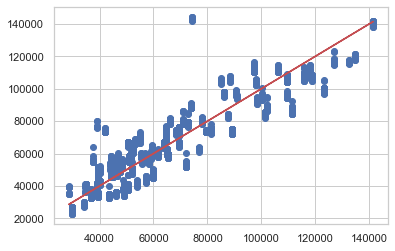

In [354]:
# Our predictions
plt.scatter(y_test, preds_lm)

# Perfect predictions
plt.plot(y_test, y_test,'r')

In [355]:
# Test data real sale price dataframe
test_salary_df = pd.DataFrame(y_test, columns=['Test Y'])

# Predicted prices dataframe
preds_reshape = pd.Series(preds_lm.reshape(3576,))
preds = pd.DataFrame(preds_reshape, columns = ['Predicted'])

# Merge real price and predicted price dataframes
compare_salary_df = pd.merge(test_salary_df, preds, how = 'inner', left_index = True, right_index = True)
compare_salary_df.head(5)

,Test Y,Predicted
0,43406.0,34495.102713
1,69590.0,64749.242041
2,52110.0,51069.933664
3,79524.0,73742.088129
4,59290.0,63680.540175


In [356]:
# Add a new column with error in prediction compared
compare_salary_df['Error'] = compare_salary_df['Test Y'] - compare_salary_df['Predicted']

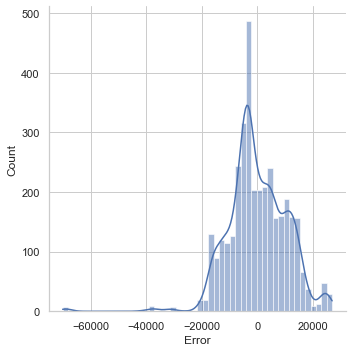

In [357]:
sns.displot(compare_salary_df['Error'], bins = 50, kde = True)

## Creating a Decision Tree model

In [371]:
from sklearn.tree import DecisionTreeRegressor

In [372]:
dtr = DecisionTreeRegressor(random_state=42)
dtr.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [373]:
dtr_preds = dtr.predict(X_test)

In [374]:
dtr_preds

array([0.13111076, 0.36333724, 0.20830673, ..., 0.15408152, 0.65140308,
       0.20830673])

### Valuating the model

In [375]:
print('R-squared', r2_score(y_test, dtr_preds)) # accounts for the variation
print('MAE:', metrics.mean_absolute_error(y_test, dtr_preds))
print('MSE:', metrics.mean_squared_error(y_test, dtr_preds))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, dtr_preds))) # directly comparable witht data, $

R-squared 1.0
MAE: 5.181506479161507e-16
MSE: 5.73902672303382e-31
RMSE: 7.575636424112379e-16


In [376]:
dtr_preds = dtr_preds.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

In [377]:
dtr_preds = scaler_y.inverse_transform(dtr_preds)
y_test = scaler_y.inverse_transform(y_test)

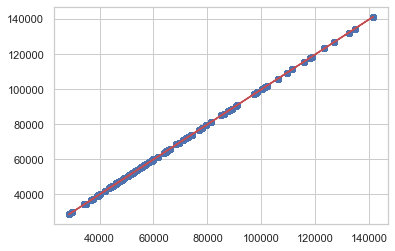

In [386]:
# Our predictions
plt.scatter(y_test, dtr_preds)

# Perfect predictions
plt.plot(y_test, y_test,'r')

In [ ]:
# TRY
one = pd.DataFrame({'Test Y':y_test, 'Predicted':y_pred})
one

In [379]:
# Test data real sale price dataframe
test_salary_df = pd.DataFrame(y_test, columns=['Test Y'])

# Predicted prices dataframe
preds_reshape = pd.Series(dtr_preds.reshape(3576,))
preds = pd.DataFrame(preds_reshape, columns = ['Predicted'])

# Merge real price and predicted price dataframes
compare_salary_df = pd.merge(test_salary_df, preds, how = 'inner', left_index = True, right_index = True)
compare_salary_df.head(5)

,Test Y,Predicted
0,43406.0,43406.0
1,69590.0,69590.0
2,52110.0,52110.0
3,79524.0,79524.0
4,59290.0,59290.0


In [380]:
# Add a new column with error in prediction compared
compare_salary_df['Error'] = compare_salary_df['Test Y'] - compare_salary_df['Predicted']

/Users/helenahook/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


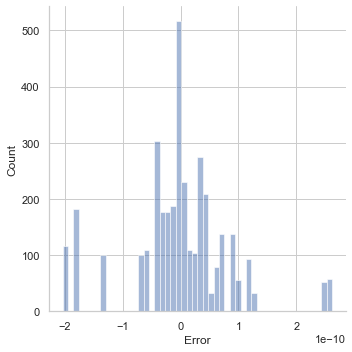

In [381]:
sns.displot(compare_salary_df['Error'], bins = 50, kde = True)

# Gradient boosting for regression

In [393]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import GradientBoostingRegressor

In [390]:
# define dataset
X, y = make_regression(n_samples=1000, n_features=20, n_informative=15, noise=0.1, random_state=7)

In [395]:
# define the model
model = GradientBoostingRegressor()
# fit the model on the whole dataset
model.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [396]:
# make a single prediction
row = [0.20543991, -0.97049844, -0.81403429, -0.23842689, -0.60704084, -0.48541492, 0.53113006, 2.01834338, -0.90745243, -1.85859731, -1.02334791, -0.6877744, 0.60984819, -0.70630121, -1.29161497, 1.32385441, 1.42150747, 1.26567231, 2.56569098, -0.11154792]
yhat = model.predict([row])
# summarize prediction
print('Prediction: %d' % yhat[0])

Prediction: 37


## Use GridSearch

In [398]:
# example of grid searching key hyperparameters for gradient boosting on a classification dataset
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

In [399]:
# define dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=7)

In [400]:
# define the model with default hyperparameters
model = GradientBoostingClassifier()

In [401]:
# define the grid of values to search
grid = dict()
grid['n_estimators'] = [10, 50, 100, 500]
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
grid['subsample'] = [0.5, 0.7, 1.0]
grid['max_depth'] = [3, 7, 9]

In [402]:
# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [403]:
# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')

In [404]:
# execute the grid search
grid_result = grid_search.fit(X, y)

KeyboardInterrupt: 

In [ ]:
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [ ]:
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}

In [ ]:
reg = ensemble.GradientBoostingRegressor(**params)

In [ ]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, reg.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()